If tnerwork library is not installed, you need to install it, for instance using the following command

In [1]:
#%%capture #avoid printing output
#!pip install --upgrade git+https://github.com/Yquetzal/tnetwork.git

In [84]:
%load_ext autoreload
%autoreload 2
import tnetwork as tn
import seaborn as sns
import pandas as pd
import networkx as nx
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating an example dynamic graph with changing community structure
We create a simple example of dynamic community evolution using the generator provided in the library. We generate a simple ship of Theseus scenario. Report to the corresponding tutorial to fully understand the generation part if needed.

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

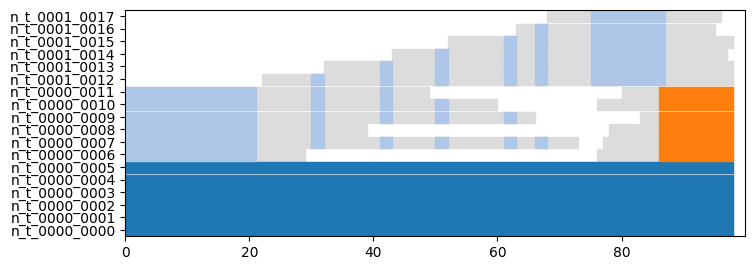

In [66]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([6,6],["c1","c2"])
(com2,com3)=my_scenario.THESEUS(com2,wait=20)
my_scenario.DEATH(com2,wait=10)

#visualization
(generated_network_IG,generated_comunities_IG) = my_scenario.run()

tn.plot_longitudinal(generated_network_IG,generated_comunities_IG,height=300)
generated_network_SN = generated_network_IG.to_DynGraphSN(slices=1)
generated_communities_SN = generated_comunities_IG.to_DynCommunitiesSN(slices=1)


Let's look at the graph at different stages, namely steps [0,2,4,5,6,8,10]

In [67]:
last_time = generated_network_IG.end()
print(last_time)
times_to_plot = [0,int(last_time/3),int(last_time/3*2),last_time-1]
tn.plot_as_graph(generated_network_IG,ts=times_to_plot,auto_show=True,width=200,height=200)

98


Loading BokehJS ...

Row(id='6657', ...)

Algorithms for community detection are located in the tnetwork.DCD package

In [68]:
import tnetwork.DCD as DCD

## First algorithm: Iterative match
Iterative match consists in applying a static algorithm at each step and matching communities in successive snapshots if they are similar. Check the doc for more details.

Without particular parameters, it uses the louvain method and the jaccard coefficient.

In [69]:
com_iterative = DCD.iterative_match(generated_network_SN)

start iterative_match, version: louvain
end iterative_match


The static algorithm, the similarity function and the threashold to consider similar can be changed

In [70]:
custom_match_function = lambda x,y: len(x&y)/max(len(x),len(y))
com_custom = DCD.iterative_match(generated_network,match_function=custom_match_function,CDalgo=nx.community.greedy_modularity_communities,threshold=0.5)

start iterative_match, version: <function greedy_modularity_communities at 0x11b7af560>
end iterative_match


## Visualizing communities

One way to visualize the evolution of communities is to plot the graph at some snapshots.
By calling the `plot_as_graph` function with several timestamps, we plot graphs at those timestamps while ensuring:

* That the position of nodes stay the same between snapshots
* That the same color in different plots means that nodes belong to the same dynamic communities

In [71]:
last_time = generated_network_IG.end()
times_to_plot = [0,int(last_time/3),int(last_time/3*2),last_time-1]
tn.plot_as_graph(generated_network_IG,generated_comunities_IG,ts=times_to_plot,auto_show=True,width=200,height=200)

Loading BokehJS ...

Row(id='7324', ...)

Another solution is to plot a longitudinal visualization: each horizontal line corresponds to a node, time is on the x axis, and colors correspond to communities. Grey means that a node corresponds to no community, white that the node is not present in the graph (or has no edges)

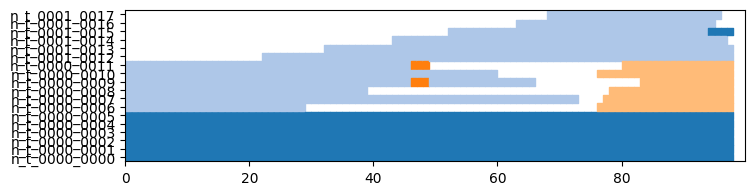

In [72]:
to_plot = tn.plot_longitudinal(generated_network_SN,com_iterative,height=200)

### Survival Graph
This method matches communities not only between successive snaphsots, but between any snapshot, constituting a survival graph on which a community detection algorithm detects communities of communities => Dynamic communities

starting survival graph method 
end of survival graph method 


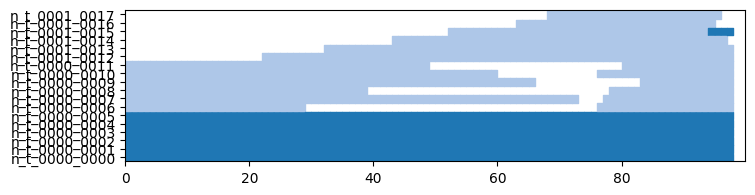

In [73]:
com_survival = DCD.match_survival_graph(generated_network_SN)
tn.plot_longitudinal(generated_network_SN,com_survival,height=200)


### Smoothed louvain
The smoothed Louvain algorihm is very similar to the simple iterative match, at the difference that, at each step, it initializes the partition of the Louvain algorithm with the previous partition instead of having each node in its own community as in usual Louvain. 

It has the same options as iterative match, since only the community detection process at each step changes, not the matching

start iterative_match, version: smoothedLouvain
end iterative_match


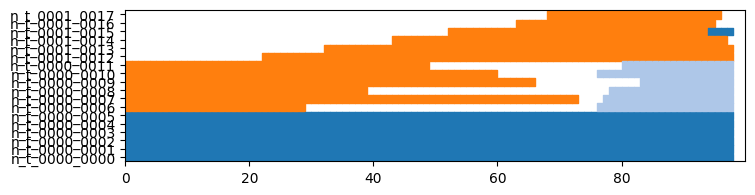

In [74]:
com_smoothed = DCD.smoothed_louvain(generated_network_SN)
tn.plot_longitudinal(generated_network_SN,com_smoothed,height=200)


### Matching with a custom function
The iterative match and survival graph methods can also be instantiated with any custom community detection algorithm at each step, and any matching function, as we can see below. The match function takes as input the list of nodes of both communities, while the community algorithm must follow the signature of networkx community detection algorithms

start iterative_match, version: <function greedy_modularity_communities at 0x11b7af560>
end iterative_match


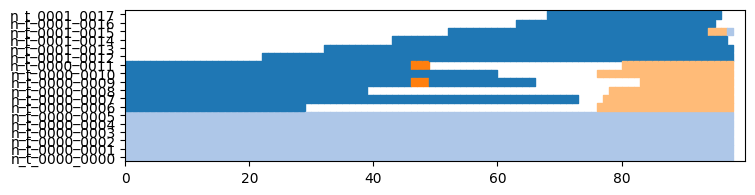

In [75]:
custom_match_function = lambda x,y: len(x&y)/max(len(x),len(y))
com_custom2 = DCD.iterative_match(generated_network_SN,match_function=custom_match_function,CDalgo=nx.community.greedy_modularity_communities)
tn.plot_longitudinal(generated_network_SN,com_custom2,height=200)


### Another algoritm in python: CPM
CPM stands for Clique Percolation Method. An originality of this approach is that it yiealds overlapping communities.

Be careful, the visualization is not currently adapted to overlapping clusters...

CD detection done 98


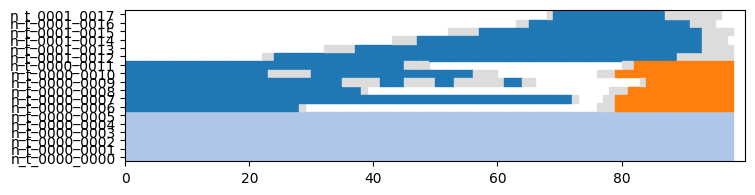

In [76]:
com_CPM = DCD.rollingCPM(generated_network_SN)
tn.plot_longitudinal(generated_network_SN,com_CPM,height=200)

## Dynamic partition evaluation
The goal of this section is to present the different types of dynamic community evalutation implemented in tnetwork.

For all evaluations below, no conclusion should be drawn about the quality of algorithms... .

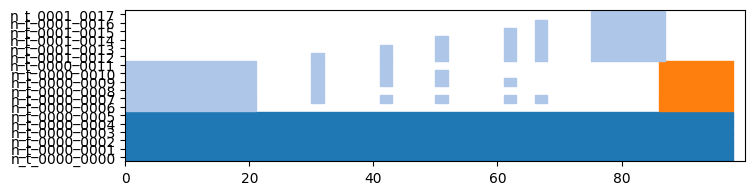

In [77]:
#Visualization
tn.plot_longitudinal(communities=generated_comunities_IG,height=200,sn_duration=1)

### Quality at each step
The first type of evaluation we can do is simply to compute, at each type, a quality measure. By default, the method uses Modularity, but one can provide to the function its favorite quality function instead. It is the simplest adaptation of *internal evaluation*.

Note that 
 * the result of an iterative approach is identical to the result of simply applying a static algorithm at each step 
 * Smoothing therefore tend to lesser the scores.
 * The result migth or might not be computable at each step depending on the quality function used (e.g., modularity requires a complete partition of the networks to be computed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123312e90>,
      dtype=object)

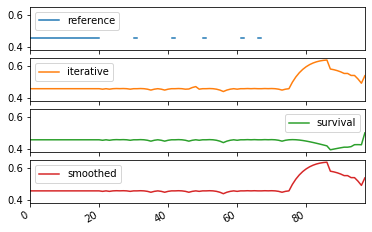

In [89]:
quality_ref,sizes_ref = DCD.quality_at_each_step(generated_communities_SN,generated_network_SN)
quality_iter,sizes_iter = DCD.quality_at_each_step(com_iterative,generated_network_SN)
quality_survival,sizes_survival = DCD.quality_at_each_step(com_survival,generated_network_SN)
quality_smoothed,sizes_smoothed = DCD.quality_at_each_step(com_smoothed,generated_network_SN)

df = pd.DataFrame({"reference":quality_ref,"iterative":quality_iter,"survival":quality_survival,"smoothed":quality_smoothed})
df.plot(subplots=True,sharey=True)


### Average values
One can of course compute average values over all steps. Be careful however when interpreting such values, as there are many potential biases:
* Some scores (such as modularity) are not comparable between graphs of different sizes/density, so averaging values obtained on different timesteps might be incorrect
* The *clarity* of the community structure might not be homogeneous, and your score might end up depending mostly on results on a specific period
* Since the number of nodes change in every step, we have the choice of weighting the values by the size of the network
* etc.

Since the process is the same for all later functions, we won't repeat it for the others in this tutorial

In [90]:
print("iterative=", np.average(quality_iter),"weighted:", np.average(quality_iter,weights=sizes_iter))
print("survival=", np.average(quality_survival),"weighted:", np.average(quality_survival,weights=sizes_survival))
print("smoothed=", np.average(quality_smoothed),"weighted:", np.average(quality_smoothed,weights=sizes_smoothed))

iterative= 0.4811765660092316 weighted: 0.4884307159849016
survival= 0.4495770577416834 weighted: 0.4477019633485599
smoothed= 0.48086671076659354 weighted: 0.4881325622242363


### Similarity at each step
A second type of evaluation consists in adaptating *external evaluation*, i.e., comparison with a known reference truth.

It simply computes at each step the similarity between the computed communities and the ground truth. By default, the function uses the adjusted Mutual Information (aMI or aNMI), but again, any similarity measure can be provided to the function.

Note that, as for quality at each step, smoothing is not an advantage, community identities accross steps has no impact.

There is a subtility here: since, often, the dynamic ground truth might have some nodes without affiliations, we make the choice of comparing only what is known in the ground truth, i.e., if only 5 nodes out of 10 have a community in the ground truth at time t, the score of the proposed solution will depends only on those 5 nodes, and the affiliations of the 5 others is ignored

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125399a50>,
      dtype=object)

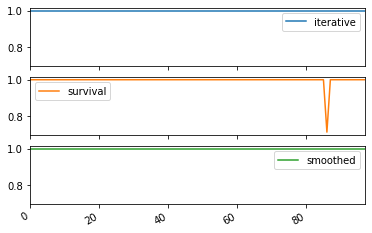

In [94]:
quality_iter,sizes = DCD.similarity_at_each_step(generated_communities_SN,com_iterative)
quality_survival,sizes = DCD.similarity_at_each_step(generated_communities_SN,com_survival)
quality_smoothed,sizes = DCD.similarity_at_each_step(generated_communities_SN,com_smoothed)

df = pd.DataFrame({"iterative":quality_iter,"survival":quality_survival,"smoothed":quality_smoothed})
df.plot(subplots=True,sharey=True)




### Smoothness
We can evaluate the smoothness of a partition by comparing how the partition in each step is similar to the partition in the next. Again, any measure can be used, by default the aMI.
* This evaluation is *internal*. 
* This time, it depends on the *labels* given to nodes accross steps, so a static algorithm applied at each step would have a score of zero.
* The score does not depends at all on the quality of the solution, i.e., having all nodes in the same partition at every step would obtain a perfect score of 1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125581e50>,
      dtype=object)

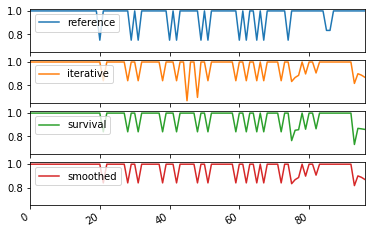

In [92]:
quality_ref,sizes_ref = DCD.consecutive_sn_similarity(generated_communities_SN)
quality_iter,sizes_iter = DCD.consecutive_sn_similarity(com_iterative)
quality_survival,sizes_survival = DCD.consecutive_sn_similarity(com_survival)
quality_smoothed,sizes_smoothed = DCD.consecutive_sn_similarity(com_smoothed)

df = pd.DataFrame({"reference":quality_ref,"iterative":quality_iter,"survival":quality_survival,"smoothed":quality_smoothed})
df.plot(subplots=True,sharey=True)




## Global scores
Another family of scores we can compute are not based on step by step computations, but rather compute directly a single score on whole communities

### Longitudinal Similarity
This score is computed using a usual similarity measure, by default the aMI as usual. But instead of computing the score for each step independently, it is computed once, consider each (node,time) pair as a data point (instead of each node in a static network). 
* The evaluation is *external*, it requires a (longitudinal) reference partition
* It takes into account both the similarity at each step and the labels accros steps
* Similar to step by step similarity, only (node,time) couples with a known affiliation in the reference partition are used, others are ignored

In [96]:
quality_iter = DCD.longitudinal_similarity(generated_communities_SN,com_iterative)
quality_survival = DCD.longitudinal_similarity(generated_communities_SN,com_survival)
quality_smoothed = DCD.longitudinal_similarity(generated_communities_SN,com_smoothed)

print("iterative: ",quality_iter)
print("survival: ",quality_survival)
print("smoothed: ",quality_smoothed)

iterative:  1.0
survival:  0.8736583115252802
smoothed:  1.0


### Global Smoothness
Two methods are proposed to evaluate the smoothness at the global level.

The first one simply computes how many changes in affiliation there are.
* It penalizes methods with many *glitches*, i.e., transient affiliation change. 
* It does not penalize long term changes

The second computes instead the entropy per node:
* It does not penalize much glitches
* It advantages solutions in which nodes tend to belong to few communities



In [105]:
print("iterative: entropy:",DCD.entropy_by_node(com_iterative), "glitches score:",DCD.nb_node_change(com_iterative))
print("survival: entropy:",DCD.entropy_by_node(com_survival), "glitches score:",DCD.nb_node_change(com_survival))
print("smoothed: entropy:",DCD.entropy_by_node(com_smoothed), "glitches score:",DCD.nb_node_change(com_smoothed))

iterative: entropy: 0.22846815041809362 glitches score: 10
survival: entropy: 0.016413288437339784 glitches score: 1
smoothed: entropy: 0.21073976914691595 glitches score: 7


ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=6659&bokeh-absolute-url=http://localhost:59387&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:59387', method='GET', uri='/autoload.js?bokeh-autoload-element=6659&bokeh-absolute-url=http://localhost:59387&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/tornado/web.py", line 1699, in _execute
    result = await result
  File "/usr/local/lib/python3.7/site-packages/bokeh/server/views/autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "/usr/local/lib/python3.7/site-packages/bokeh/server/views/session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/usr/local/lib/python3.7/site-packages/bokeh/server/contexts.py", line 218, in create_session_if_needed
    self._a